
#1st TRY

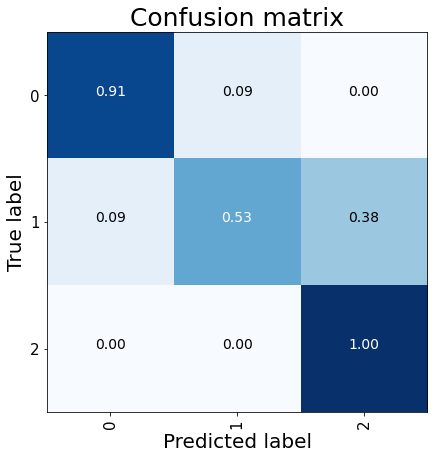

#TRY 2
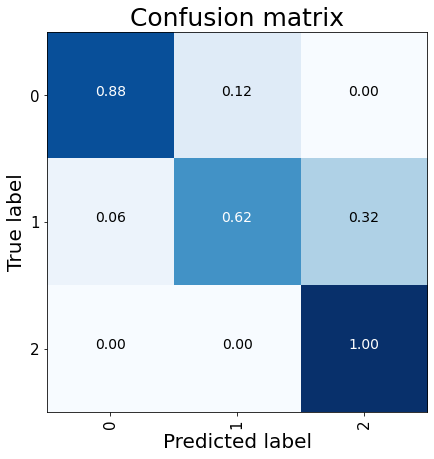

#Best Model - Accuracy-88.8

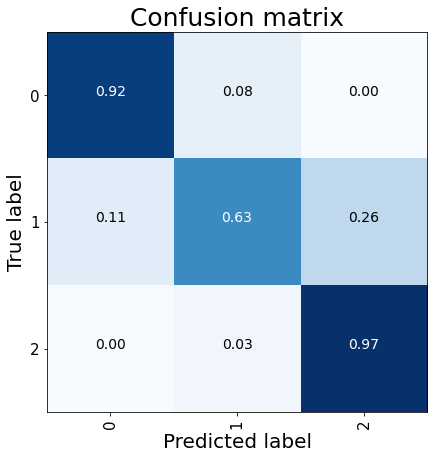

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
import bottleneck as bn

import random
import os
import keras

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
import itertools

import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV

#**PART 1: DATA ANALYSIS FOR TRAINING**

###READING THE DATA FROM THE DRIVE

In [4]:
columns = ['unit_no', 'cycles', 'oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
df_train = pd.read_csv(("drive/My Drive/Final Data/Challenge_Data - Aerostrovilos/train.txt"), sep ='\s+', header=None, names = columns)
# df_test = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/test_FD003.txt"), sep ='\s+', header=None, names = columns)
# df_RUL = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/RUL_FD003.txt"), sep ='\s+', header=None, names = ['RUL'])

In [5]:
df_train[0:5]

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [6]:
df_train.isnull().sum()

unit_no    0
cycles     0
oc_1       0
oc_2       0
oc_3       0
s_1        0
s_2        0
s_3        0
s_4        0
s_5        0
s_6        0
s_7        0
s_8        0
s_9        0
s_10       0
s_11       0
s_12       0
s_13       0
s_14       0
s_15       0
s_16       0
s_17       0
s_18       0
s_19       0
s_20       0
s_21       0
dtype: int64

###*Hence, we see that the data is clean, has no NaN, nor does it have any blank cells.*



###The below line of code finds the maximum number of cycles each unit of engine takes until failure. This will be useful to make the "Remaining Useful Life" column

In [7]:
max_cycles_train = df_train.groupby(['unit_no'], sort=False)['cycles'].max().reset_index().rename(columns={'cycles':'MaxCycleID'})

###In the below cell, we are adding 2 new columns to the Dataframe, namely "MaxCycleID" and "RUL". "MaxCycleID" is the total number of cycles the unit took to fail. Then we subtract the number of cycles that have been performed, from the total number of cycles the unit took to fail.This gives the Remaining Useful Life, which is stored in the column "RUL".

In [8]:
df_train = pd.merge(df_train, max_cycles_train, how='inner', on='unit_no')
df_train['RUL'] = df_train['MaxCycleID'] - df_train['cycles']
df_train

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,MaxCycleID,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,223,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,223,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,223,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,223,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,223,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,133,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,133,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,133,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,133,1


In [9]:
print(np.max(np.array(df_train['MaxCycleID'])))

357


###Now we delete the column "MaxCycleID", since we have found the RUL.

In [10]:
df_train = df_train.drop(labels='MaxCycleID', axis=1)
df_train

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,1


###IN THE BELOW CELL, WE ARE SAVING THE COLUMN FOR REMIANING USEFUL LIFE IN THE VARIABLE 'RUL'. THEN WE CONVERT THIS ARRAY INTO A DATAFRAME AND SAVE IT IN THE VARIABLE "df_train_y_final" FOR FUTURE USE. WE THEN SAVE THE COLUMNS "cycles", & "unit_no" IN THE VARIABLES "cycles" & "unit". NOW WE DROP THESE COLUMNS, TO GET THE DATASET WITH ONLY OPERATIONAL CONDITIONS AND SENSOR READINGS, i.e. THE DATA POINTS THAT MAY PLAY A ROLE IN PREDICTION.

In [11]:
unit= df_train['unit_no'].values
unit = unit[~np.isnan(unit)]
L= len(unit)
RUL= df_train['RUL'].values
RUL= RUL[~np.isnan(RUL)]

################################################################
df_train_y_final = pd.DataFrame(RUL)
################################################################

cycles = df_train['cycles'].values
df_train_temp = df_train.drop(labels={'RUL','unit_no','cycles'}, axis=1)
df_train_temp

,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735
1,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619
2,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555
3,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832
4,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985
45914,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741
45915,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978
45916,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761


##BEFORE THE BELOW SCALING, WE NEED TO FIND CLUSTERS AND THEN SCALE WITHIN THE CLUSTERS

###################################################################################

IN THE BELOW CELL, WE ARE TAKING OUT THE THREE COLUMNS  CONTAINING INFORMATION ABOUT THE OPERATION CONDITION, SO THAT WE CAN CLUSTER THE DATA BASED ON THE OPERATION CONDITIONS.

In [12]:
OpConditionData = df_train_temp[['oc_1','oc_3','oc_3']]
OpConditionData

,oc_1,oc_3,oc_3
0,10.0047,20.0,20.0
1,0.0015,100.0,100.0
2,34.9986,60.0,60.0
3,20.0031,0.0,0.0
4,42.0041,40.0,40.0
...,...,...,...
45913,42.0066,40.0,40.0
45914,42.0029,40.0,40.0
45915,41.9999,40.0,40.0
45916,35.0007,60.0,60.0


NOW, WE WANT TO KNOW THE NUMBER OF CLUSTERS OF OPERATION CONDITIONS EXISTING IN THE DATA. TO FIND THAT, WE ARE LOOPING THROUGH THE DATASET, AND MAKING CLUSTERS-STARTING AT 1 CLUSTER, AND GOING ON TILL 20 CLUSTERS. WE USE THE INERTIA MEASURE OF HOW GOOD A CLUSTER IS. 



> Inertia is the sum of squared error for each cluster. Therefore the smaller the inertia the denser the cluster(closer together all the points are)


Cluster 1 Inertia 107070571.76736699
Cluster 2 Inertia 34410931.26043652
Cluster 3 Inertia 11656627.038067702
Cluster 4 Inertia 6163216.049687007
Cluster 5 Inertia 3071721.1771970303
Cluster 6 Inertia 0.33231808458003476
Cluster 7 Inertia 0.259318326617995
Cluster 8 Inertia 0.2156968607076085
Cluster 9 Inertia 0.1732963728857973
Cluster 10 Inertia 0.1307877326744836
Cluster 11 Inertia 0.08935125408799985
Cluster 12 Inertia 0.0745317772632592
Cluster 13 Inertia 0.06860280403727179
Cluster 14 Inertia 0.05885395416565398
Cluster 15 Inertia 0.050537565816140904
Cluster 16 Inertia 0.04577014376199328
Cluster 17 Inertia 0.03733215071884238
Cluster 18 Inertia 0.0335447795910078
Cluster 19 Inertia 0.03105385071322024


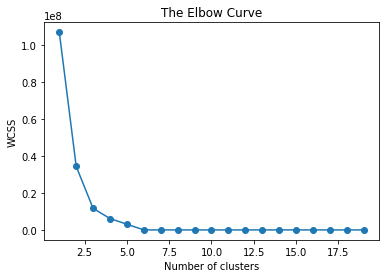

In [13]:
wcss = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=500,n_init=10,random_state=0)
    kmeans.fit(OpConditionData)
    wcss.append(kmeans.inertia_)
    print("Cluster", i, "Inertia", kmeans.inertia_)
plt.scatter(range(1,20),wcss)
plt.plot(range(1,20),wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') ##WCSS stands for total within-cluster sum of square
plt.show()

FROM THE ABOVE GRAPH, WE SEE THAT THE INERTIA DRASTICALLY DECREASES INITIALLY, BUT AFTER 6 CLUSTERS, THE CHANGE IN INERTIA IS NEGLIGIBLE. HENCE, IT IS DECIDED THAT 6 IS THE OPTIMUM NUMBER OF CLUSTERS. 

IN THE BELOW CELL, WE CLUSTER THE OPERATION CONDITIONS INTO 6 CLUSTERS.

In [14]:
kmean=KMeans(n_clusters=6)
kmean.fit(OpConditionData)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

JUST TO GET A VISUAL REPRESENTATION OF THE CLUSTERS, IT IS PLOTTED ON A 3D GRAPH, WITH THE 3 AXES PERTAINING TO THE 3 OPERATION SETTINGS.

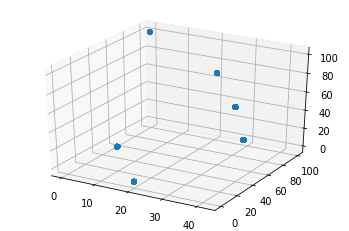

In [15]:
ax = plt.axes(projection='3d')
OpConditionData1 = np.array(OpConditionData)
# Data for three-dimensional scattered points
xdata = OpConditionData1[:,0]
ydata = OpConditionData1[:,1]
zdata = OpConditionData1[:,2]
ax.scatter3D(xdata, ydata, zdata,  cmap='Blues');#c=zdata, cmap='Blues');

FROM THE ABOVE GRAPH, WE SEE THAT 6 DISTINCT CLUSTERS HAVE BEEN FORMED.

###NOW, WE HAVE FORMED THE CLUSTERS.
NEXT, WE WANT TO DIVIDE THE DATASET ON THE BASIS OF THESE CLUSTERS, SO THAT WE CAN SCALE THE DATA(i.e. NORMALIZE) WITHIN EACH CLUSTER.

INORDER TO DIVIDE THE DATASET, WE FIRST GET THE INDEX LOCATIONS OF DATA POINTS IN EACH CLUSTER, AND SAVE IT IN THE RESPECTIVE VARIABLE(for e.g., cluster0_index, contains index locations of all data points in 0th cluster.)

In [16]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = OpConditionData.index.values
cluster_map['cluster'] = kmean.labels_

cluster0 = cluster_map[cluster_map.cluster == 0]
cluster0_index = np.array(cluster0[['data_index']])
cluster0_index = cluster0_index.reshape((len(cluster0_index),))

cluster1 = cluster_map[cluster_map.cluster == 1]
cluster1_index = np.array(cluster1[['data_index']])
cluster1_index = cluster1_index.reshape((len(cluster1_index),))

cluster2 = cluster_map[cluster_map.cluster == 2]
cluster2_index = np.array(cluster2[['data_index']])
cluster2_index = cluster2_index.reshape((len(cluster2_index),))

cluster3 = cluster_map[cluster_map.cluster == 3]
cluster3_index = np.array(cluster3[['data_index']])
cluster3_index = cluster3_index.reshape((len(cluster3_index),))

cluster4 = cluster_map[cluster_map.cluster == 4]
cluster4_index = np.array(cluster4[['data_index']])
cluster4_index = cluster4_index.reshape((len(cluster4_index),))

cluster5 = cluster_map[cluster_map.cluster == 5]
cluster5_index = np.array(cluster5[['data_index']])
cluster5_index = cluster5_index.reshape((len(cluster5_index),))

NOW THAT WE HAVE THE INDEX LOCATION, WE ADD A COLUMN, 'Cluster_Index' TO THE WHOLE DATASET FOR EASE OF DIVISION OF THE DATASET. THIS IS DONE IN THE BELOW CELL.

In [17]:
df_train_temp['Cluster_Index'] = np.nan
df_train_temp_array = np.array(df_train_temp)
df_train_temp_array[cluster0_index, 24] = 0
df_train_temp_array[cluster1_index, 24] = 1
df_train_temp_array[cluster2_index, 24] = 2
df_train_temp_array[cluster3_index, 24] = 3
df_train_temp_array[cluster4_index, 24] = 4
df_train_temp_array[cluster5_index, 24] = 5
df_train_temp2 = pd.DataFrame(df_train_temp_array)
df_train_temp2.columns =['oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21','Cluster_Index'] 
df_train_temp2 = df_train_temp2.drop(labels='oc_1', axis=1)
df_train_temp2 = df_train_temp2.drop(labels='oc_2', axis=1)
df_train_temp2 = df_train_temp2.drop(labels='oc_3', axis=1)
df_train_temp2.insert(0, column='Sl_No', value=range(45918))
df_train_temp2

,Sl_No,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,Cluster_Index
0,0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368.0,2319.0,100.00,28.58,17.1735,2.0
1,1,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391.0,2388.0,100.00,38.99,23.3619,1.0
2,2,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334.0,2223.0,100.00,14.83,8.8555,5.0
3,3,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364.0,2324.0,100.00,24.42,14.7832,4.0
4,4,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330.0,2212.0,100.00,10.99,6.4025,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,45913,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333.0,2212.0,100.00,10.57,6.2985,0.0
45914,45914,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332.0,2212.0,100.00,10.40,6.2741,0.0
45915,45915,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334.0,2212.0,100.00,10.37,6.1978,0.0
45916,45916,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337.0,2223.0,100.00,14.70,8.6761,5.0


IN THE BELOW CELL, WE GET THE DATA POINT LOCATIONS OF EACH CLUSTER. THIS CAN THEN BE DIRECTLY USED TO GET ALL DATA POINTS IN A CLUSTER.

In [18]:
cluster_0 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 0]
cluster_1 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 1]
cluster_2 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 2]
cluster_3 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 3]
cluster_4 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 4]
cluster_5 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 5]

BEFORE DIVIDING, WE ADD A NEW COLUMN, "Sl_No", WHICH SHALL HOLD THE ORIGINAL LOCATION OF DATA POINTS IN THE DATASET. THIS IS DONE BECAUSE THE DATASET WE ARE USING IS A RUN-TO-FAILURE DATA, AND SO, THE ORDER OF DATA MATTERS AND SHOULD NOT BE JUMBLED. THE CLUSTERS DO NOT FOLLOW ANY ORDER AND SO WE WOULD LOSE TRACK, ONCE WE SPLIT THE DATASET. HENCE, THE SERIAL NUMBER COMES IN HANDY TO REORDER THE DATA.

IN THE BELOW CELL, WE SAVE Sl_No's PERTAINING TO EACH CLUSTER, AND THEN DROP THIS COLUMN. THIS IS BECAUSE WE DON'T WANT THE SERIAL NUMBER COLUMN TO BE SCALED/NORMALIZED. WE CAN INSERT THE Sl_No BACK ONCE WE ARE DONE SCALING THE DATA.

In [19]:
sl0 = cluster_0['Sl_No'].values
cluster_0_final = cluster_0.drop(['Sl_No','Cluster_Index'], axis=1)

sl1 = cluster_1['Sl_No'].values
cluster_1_final = cluster_1.drop(['Sl_No','Cluster_Index'], axis=1)

sl2 = cluster_2['Sl_No'].values
cluster_2_final = cluster_2.drop(['Sl_No','Cluster_Index'], axis=1)

sl3 = cluster_3['Sl_No'].values
cluster_3_final = cluster_3.drop(['Sl_No','Cluster_Index'], axis=1)

sl4 = cluster_4['Sl_No'].values
cluster_4_final = cluster_4.drop(['Sl_No','Cluster_Index'], axis=1)

sl5 = cluster_5['Sl_No'].values
cluster_5_final = cluster_5.drop(['Sl_No','Cluster_Index'], axis=1)


WE ARE USING A LIBRARY FUNCTION, StandardScaler() TO SCALE THE DATA. IT SCALES THE DATASET SO THAT MEAN OF EACH COLUMN BECOMES 0, AND STANDARD DEVIATION BECOMES 1.(OF EACH CLUSTER SPEARATELY)

AFTER SCALING, WE INSERT THE SERIAL NUMBER COLUMN BACK INTO EACH CLUSTER-DATA.

In [20]:
sc = StandardScaler()
cluster_0_scaled = pd.DataFrame(sc.fit_transform(cluster_0_final))
cluster_1_scaled = pd.DataFrame(sc.fit_transform(cluster_1_final))
cluster_2_scaled = pd.DataFrame(sc.fit_transform(cluster_2_final))
cluster_3_scaled = pd.DataFrame(sc.fit_transform(cluster_3_final))
cluster_4_scaled = pd.DataFrame(sc.fit_transform(cluster_4_final))
cluster_5_scaled = pd.DataFrame(sc.fit_transform(cluster_5_final))

cluster_0_scaled.insert(0, column='Sl_No', value=sl0)
cluster_1_scaled.insert(0, column='Sl_No', value=sl1)
cluster_2_scaled.insert(0, column='Sl_No', value=sl2)
cluster_3_scaled.insert(0, column='Sl_No', value=sl3)
cluster_4_scaled.insert(0, column='Sl_No', value=sl4)
cluster_5_scaled.insert(0, column='Sl_No', value=sl5)


NOW THAT WE ARE DONE SCALING, WE JOIN ALL THE 6 CLUSTER-DATASETS, TOGETHER, AND REARRANGE IT SO THAT SERIAL NUMBER IS IN AXSCENDING ORDER. THIS MAKES SURE THAT THE ORIGINAL ORDER OF DATASET IS PRESERVED.

In [21]:
data_train_regime_scaled = pd.concat([cluster_0_scaled,cluster_1_scaled,cluster_2_scaled,cluster_3_scaled,cluster_4_scaled,cluster_5_scaled],ignore_index=True)
data_train_scaled = data_train_regime_scaled.sort_values(by=['Sl_No'], inplace=False, ignore_index=True)
df_train_scaled = data_train_scaled.drop(labels='Sl_No', axis=1)
df_train_scaled.columns =['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
df_train_scaled.insert(0, "unit_no", unit, True) 
df_train_scaled.insert(1, "cycles", cycles, True) 
df_train_scaled

,unit_no,cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-1.0,-1.665753,-0.460783,-0.168939,1.0,-0.699491,0.854771,-0.979801,-0.778629,0.000000,-0.381680,1.356156,-0.360239,-0.822727,-1.170346,-1.000000,-1.181068,0.0,0.0,0.377665,0.675931
1,1,2,0.0,-1.201516,-1.040896,-0.626351,-1.0,0.117058,0.423962,-1.379941,-0.837893,-1.000000,-1.033360,0.637742,0.652784,-0.472053,-1.468435,-1.000000,-1.520270,0.0,0.0,1.036586,0.735222
2,1,3,1.0,-0.920644,0.218754,-1.283286,-1.0,-0.173751,1.060740,-0.561708,-0.646329,-0.178589,-0.335437,0.668924,-0.545028,-0.461180,0.550787,1.000000,-0.205357,0.0,0.0,0.022285,-0.595899
3,1,4,1.0,-1.212695,0.422400,-0.577347,1.0,-1.476105,0.608401,-1.335809,-0.431145,0.555343,-0.877883,-0.016307,-0.651581,-0.817109,-0.314208,-0.548739,-1.005757,0.0,0.0,-0.202160,1.411696
4,1,5,0.0,-0.456473,-0.034710,-0.513983,1.0,-1.173020,-0.856431,-0.500077,-0.689584,-0.148603,-1.595495,-0.271850,-0.429287,-0.286506,-2.132402,0.000000,-0.793951,0.0,0.0,3.771267,0.808197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,0.0,2.960030,1.870192,2.545515,1.0,0.852501,-1.466383,-2.057484,-1.317894,-0.148603,2.202003,-0.943040,-1.964938,-1.536489,2.439832,0.000000,1.334596,0.0,0.0,-0.126274,-0.823102
45914,218,130,0.0,0.796245,1.919624,1.854447,1.0,-1.173020,-2.392605,-2.190029,-1.346102,-0.148603,1.945992,-0.855494,-2.302782,-1.585767,2.296103,0.000000,0.625080,0.0,0.0,-1.703850,-1.205829
45915,218,131,0.0,0.454595,0.800340,2.905611,1.0,0.852501,-1.285657,-2.355710,-0.974426,-0.148603,2.842031,-1.964416,-2.149217,-1.544902,2.860174,0.000000,2.044111,0.0,0.0,-1.982245,-2.402638
45916,218,132,1.0,1.651665,2.319687,1.833978,-1.0,-0.173751,0.344959,-1.693518,-1.414847,-0.178589,2.669020,-2.580569,-1.831100,-1.785693,2.268910,1.000000,1.943998,0.0,0.0,-1.133010,-3.193441


** #####################################################################################**

#**DATA PLOTTING AND FEATURE SELECTION**

### IN THE PREVIOUS MODULE, WE HAVE CLUSTERED AND SCALED THE DATA SO THAT IT IS READY FOR TRAINING. HOWEVER, BEFORE TRAINING OUR MODEL, WE CAN CHOOSE A SET OF SENSOR READINGS WHICH SHOW SOME TREND WITH THE REMAINING USEFUL LIFE. WE CAN DELETE ANY REDUNDANT SENSOR READINGS MAKING THE TRAINING FASTER, AS WELL AS MORE ACCURATE.

IN THE BELOW CELL, ALL THE EACH GRAPH REPRESENTS THE VARIATION OF A SENSOR MEASUREMENT WITH THE NUMBER OF CYCLES. ALL THE UNITS HAVE BEEN PLOTTED TOGETHER, TO GET A ROUGH IDEA OF THE TRENDS.

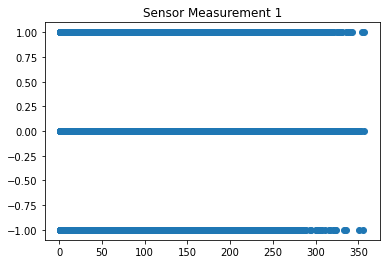

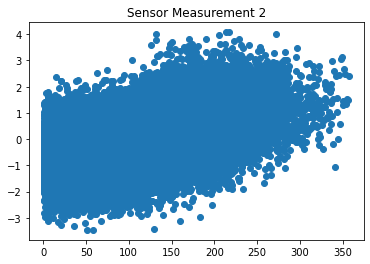

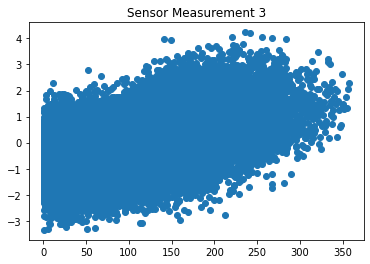

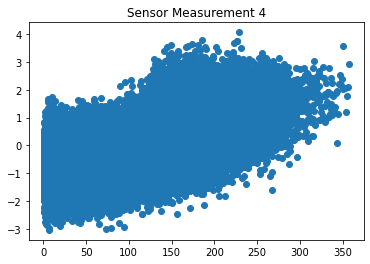

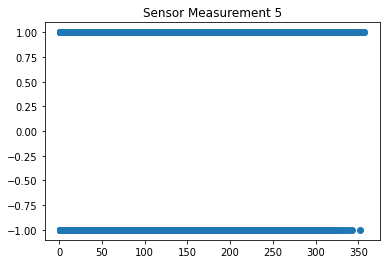

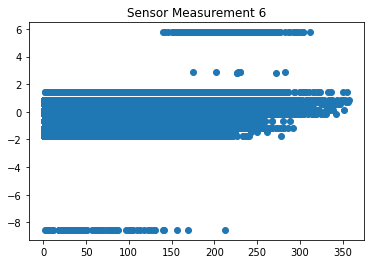

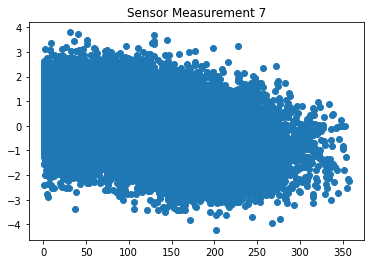

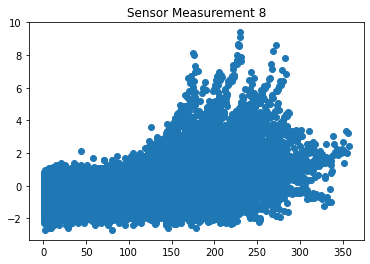

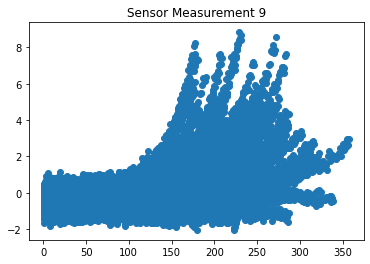

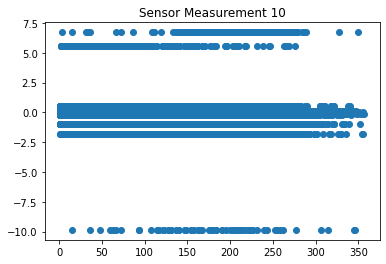

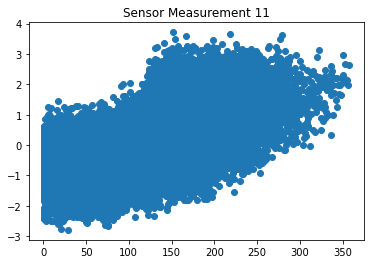

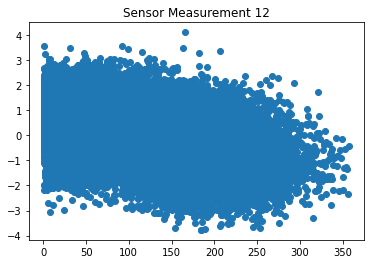

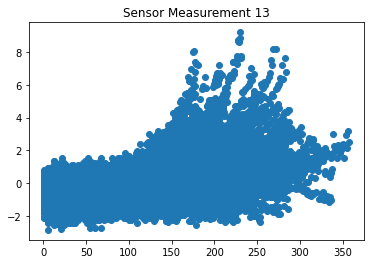

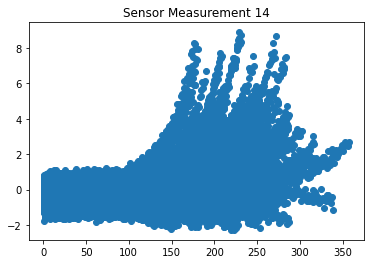

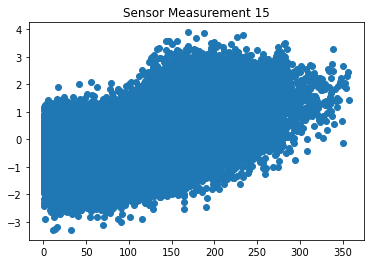

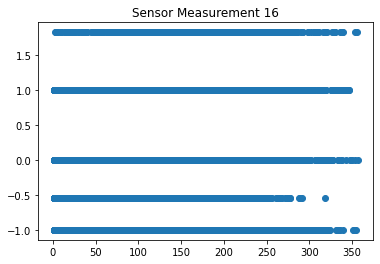

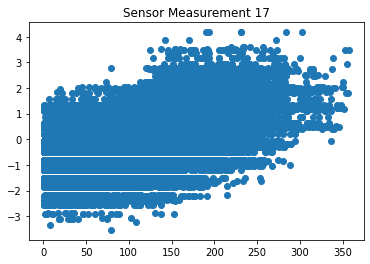

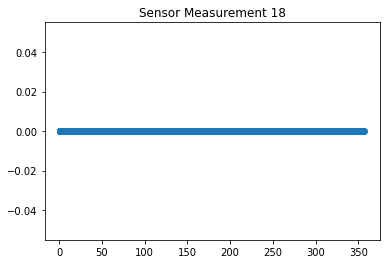

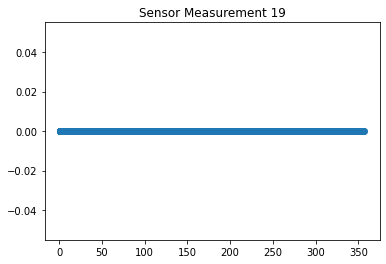

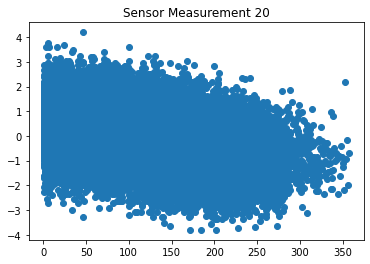

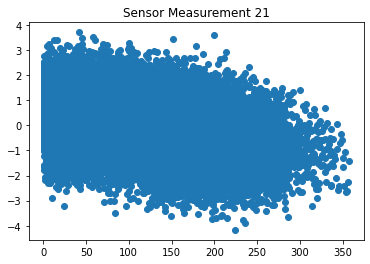

In [22]:
for i in range(1,22):
    plt.figure()
    temp= df_train_scaled['s_'+str(i)].values
    temp= temp[~np.isnan(temp)]
    plt.scatter(cycles,temp)
    plt.title('Sensor Measurement '+str(i))
    plt.show(block= False)

FROM THE ABOVE PLOTS WE CAN DIRECTLY SEE THAT READINGS FROM SENSORS 1, 5, 6, 10 16, 18 & 19 SHOW NO TREND AND SO CAN BE DROPPED WHILE TRAINING THE MODEL.

IN THE BELOW CELL, WE USE A LIBRARY FUNTION, randrange(), TO GENERATE 5 RANDOM INTEGERS BETWEEN 1 ANS 219.

In [23]:
from random import randrange
p = np.zeros(5)
for i in range(5):
    p[i] = randrange(101)
print(p)

[87.  5. 31. 56. 71.]


WE HAVE A ROUGH IDEA FROM THE PLOTS SHOWN EARLIER. TO GET A BETTER IDEA, WE PLOT THE VARIATION OF SENSOR MEASUREMENTS, FOR 5 UNITS ALONE, THE UNITS BEING THE 5 RANDOM INTEGERS GENERATED IN THE PREVIOUS CELL.

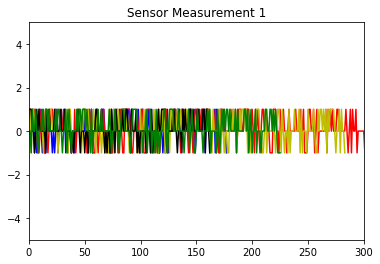

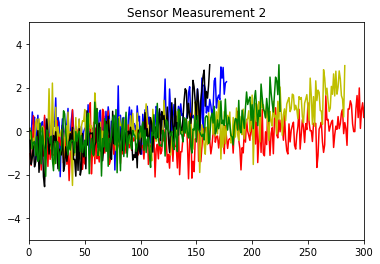

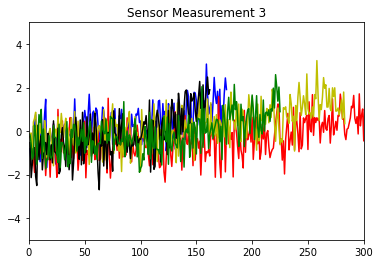

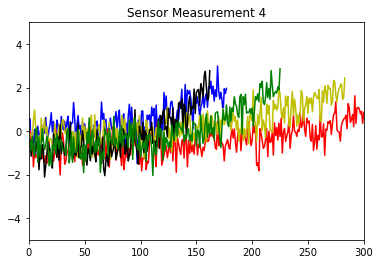

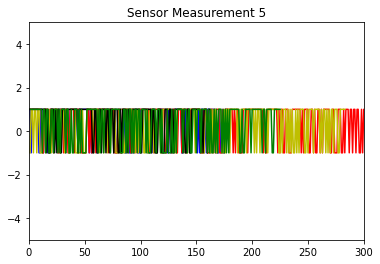

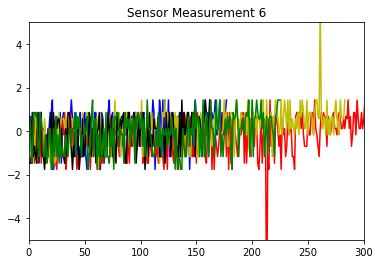

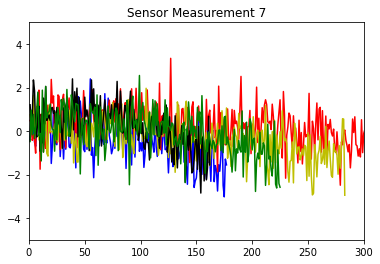

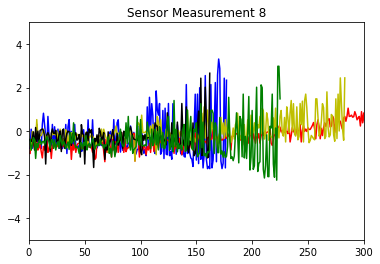

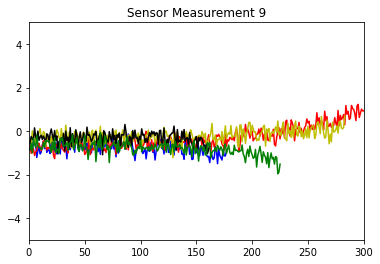

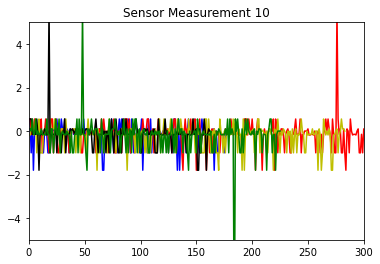

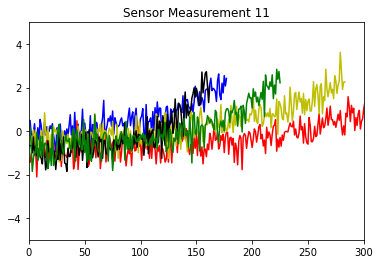

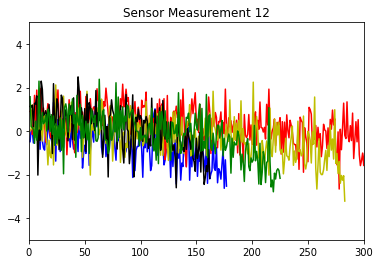

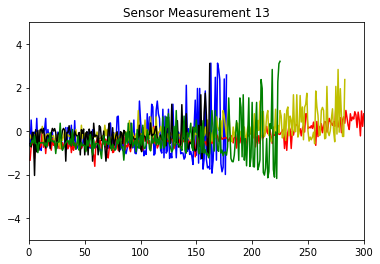

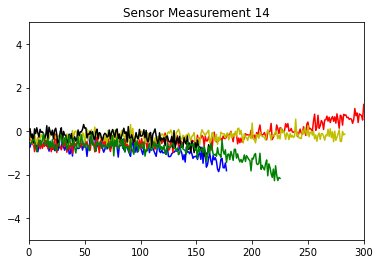

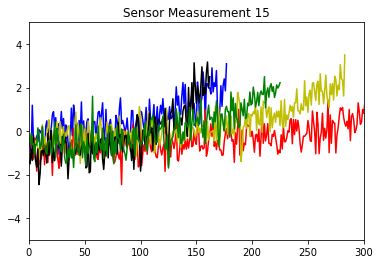

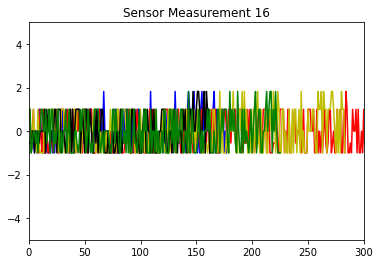

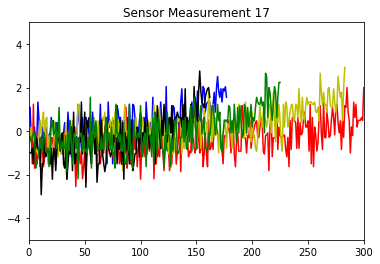

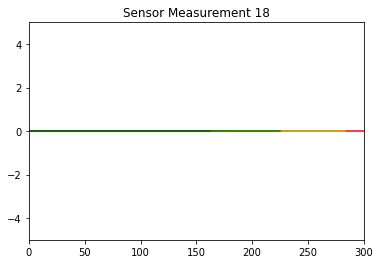

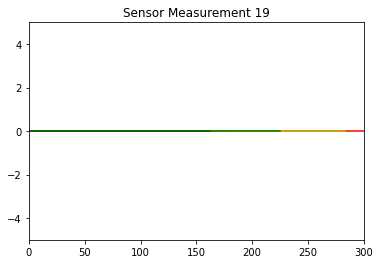

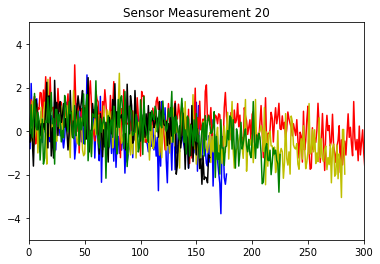

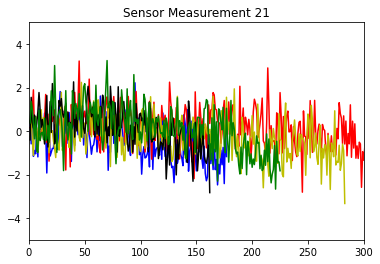

In [24]:
for i in range(1,22):
    plt.figure()
    for j,col in [[p[0],'b'],[p[1],'r'],[p[2],'y'],[p[3],'black'],[p[4],'g']]:
        data_unit = df_train_scaled[df_train['unit_no'] == j] 
        cycles_unit = data_unit['cycles'].values
        temp= data_unit['s_'+str(i)].values
        temp= temp[~np.isnan(temp)]
        plt.plot(cycles_unit,temp, c = col)
        plt.ylim([-5,5])
        plt.xlim([0,300])

    plt.title('Sensor Measurement '+str(i))
    plt.show(block= False)
# for i in range(1,4):
#     plt.figure()
#     for j,col in [[p[0],'b'],[p[1],'r'],[p[2],'y'],[p[3],'black'],[p[4],'g']]:
#         data_unit = df_train_scaled[df_train['unit_no'] == j] 
#         cycles_unit = data_unit['cycles'].values
#         temp= data_unit['oc_'+str(i)].values
#         temp= temp[~np.isnan(temp)]
#         plt.plot(cycles_unit,temp, c = col)
#         plt.ylim([-5,5])
#         plt.xlim([0,300])
#     plt.title('Operational Condition '+str(i))
#     plt.show(block= False)


### AFTER CAREFUL OBSERVATIONS FOR MANY DIFFERENT SETS OF RANDOM UNITS, IT HAS BEEN CONCLUDED THAT THE SENSORS **[s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17]** SHOW OBSERVABLE TREND. HENCE, THESE SENSORS ARE APT FOR TRAINING THE MODEL.

IN THE BELOW CELL, WE TAKE OUT THE REQUIRED SENSORS ALONE AND SAVE IN AS THE TRAINING FEATURE SET

In [25]:
S= np.ndarray(shape=(L,0))
sen = [2,3,4,7,11,12, 15,17]

num_sen= len(sen)
for i in sen:
    temp= df_train_scaled['s_' + str(i)].values
    temp = temp[~np.isnan(temp)].reshape(L, 1)
    S= np.hstack((S,temp))

In [26]:
df_train_x_final = pd.DataFrame(S)
df_train_x_final.columns =['s_2', 's_3', 's_4', 's_7','s_11', 's_12', 's_15', 's_17'] 
df_train_x_final.insert(0, "unit_no", unit, True) 
df_train_x_final.insert(1, "cycles", cycles, True)
####################################################################################################
df_train_x_final
####################################################################################################

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17
0,1,1,-1.665753,-0.460783,-0.168939,0.854771,-0.381680,1.356156,-1.170346,-1.181068
1,1,2,-1.201516,-1.040896,-0.626351,0.423962,-1.033360,0.637742,-1.468435,-1.520270
2,1,3,-0.920644,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357
3,1,4,-1.212695,0.422400,-0.577347,0.608401,-0.877883,-0.016307,-0.314208,-1.005757
4,1,5,-0.456473,-0.034710,-0.513983,-0.856431,-1.595495,-0.271850,-2.132402,-0.793951
...,...,...,...,...,...,...,...,...,...,...
45913,218,129,2.960030,1.870192,2.545515,-1.466383,2.202003,-0.943040,2.439832,1.334596
45914,218,130,0.796245,1.919624,1.854447,-2.392605,1.945992,-0.855494,2.296103,0.625080
45915,218,131,0.454595,0.800340,2.905611,-1.285657,2.842031,-1.964416,2.860174,2.044111
45916,218,132,1.651665,2.319687,1.833978,0.344959,2.669020,-2.580569,2.268910,1.943998


IN THE BELOW CELL, THE GRAPH FOR PRINCIPAL COMPONENT ANALYSIS IS PLOTTED. WE SEE THAT THE THE GRAPH IS INCREASING THROUGHOUT, REAFFIRMING THAT THE 8 FEATURES ARE NEEDED FOR A PROPER TRAINING.

Text(0, 0.5, 'Cumulative explained variance')

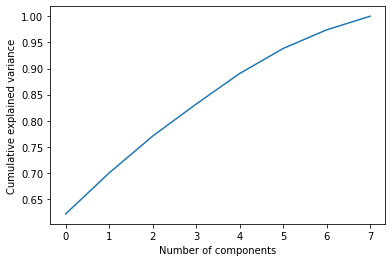

In [27]:
df_train_x_forPCA = df_train_x_final.drop(["unit_no","cycles"],axis=1)
pca = PCA(n_components=8)
pca.fit(df_train_x_forPCA)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

#**PERFORMING THE ABOVE OPERATIONS ON TEST DATA**(Here, for test, we are using the test data provided in Nasa TurboFan Data, FD001)

In [28]:
columns = ['unit_no', 'cycles', 'oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
df_test = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/test_FD001.txt"), sep ='\s+', header=None, names = columns)
df_RUL = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/RUL_FD001.txt"), sep ='\s+', header=None, names = ['RUL'])

In [29]:
df_RUL['unit_no'] = range(1,101)
df_RUL

,RUL,unit_no
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [30]:
max_cycles_test = df_test.groupby(['unit_no'], sort=False)['cycles'].max().reset_index().rename(columns={'cycles':'MaxCycleID'}) 
df_test_merge_with_MaxCycle = pd.merge(df_test, max_cycles_test, how='inner', on='unit_no')
df_test_merge_with_RUL = pd.merge(df_test_merge_with_MaxCycle, df_RUL, how='inner', on='unit_no')
df_test_merge_with_RUL = df_test_merge_with_RUL.rename(columns={'RUL':'RUL_Temp'}) 
df_test_merge_with_RUL['RUL'] = df_test_merge_with_RUL['RUL_Temp'] + df_test_merge_with_RUL['MaxCycleID'] - df_test_merge_with_RUL['cycles']
df_test_temp = df_test_merge_with_RUL.drop(labels={'RUL_Temp','MaxCycleID'}, axis=1)


In [31]:
df_test_temp

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [32]:
True_RUL = df_test_temp['RUL'].values
df_test_y_final = pd.DataFrame(True_RUL)
df_test_y_final.columns = ['RUL']
#########################################################
df_test_y_final
#########################################################

,RUL
0,142
1,141
2,140
3,139
4,138
...,...
13091,24
13092,23
13093,22
13094,21


In [33]:
df_test_temp2 = df_test_temp.drop('RUL', axis = 1)
df_test_temp2

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [34]:
OpConditionData = df_test_temp2[['oc_1','oc_3','oc_3']]
OpConditionData

,oc_1,oc_3,oc_3
0,0.0023,100.0,100.0
1,-0.0027,100.0,100.0
2,0.0003,100.0,100.0
3,0.0042,100.0,100.0
4,0.0014,100.0,100.0
...,...,...,...
13091,0.0049,100.0,100.0
13092,-0.0011,100.0,100.0
13093,-0.0006,100.0,100.0
13094,-0.0038,100.0,100.0


In [35]:
kmean=KMeans(n_clusters=6)
kmean.fit(OpConditionData)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [36]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = OpConditionData.index.values
cluster_map['cluster'] = kmean.labels_

cluster0 = cluster_map[cluster_map.cluster == 0]
cluster0_index = np.array(cluster0[['data_index']])
cluster0_index = cluster0_index.reshape((len(cluster0_index),))

cluster1 = cluster_map[cluster_map.cluster == 1]
cluster1_index = np.array(cluster1[['data_index']])
cluster1_index = cluster1_index.reshape((len(cluster1_index),))

cluster2 = cluster_map[cluster_map.cluster == 2]
cluster2_index = np.array(cluster2[['data_index']])
cluster2_index = cluster2_index.reshape((len(cluster2_index),))

cluster3 = cluster_map[cluster_map.cluster == 3]
cluster3_index = np.array(cluster3[['data_index']])
cluster3_index = cluster3_index.reshape((len(cluster3_index),))

cluster4 = cluster_map[cluster_map.cluster == 4]
cluster4_index = np.array(cluster4[['data_index']])
cluster4_index = cluster4_index.reshape((len(cluster4_index),))

cluster5 = cluster_map[cluster_map.cluster == 5]
cluster5_index = np.array(cluster5[['data_index']])
cluster5_index = cluster5_index.reshape((len(cluster5_index),))

In [37]:
df_test_temp2['Cluster_Index'] = np.nan
df_test_temp2_array = np.array(df_test_temp2)
df_test_temp2_array[cluster0_index, 26] = 0
df_test_temp2_array[cluster1_index, 26] = 1
df_test_temp2_array[cluster2_index, 26] = 2
df_test_temp2_array[cluster3_index, 26] = 3
df_test_temp2_array[cluster4_index, 26] = 4
df_test_temp2_array[cluster5_index, 26] = 5
df_test_temp3 = pd.DataFrame(df_test_temp2_array)
df_test_temp3.columns =['unit_no', 'cycles', 'oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21','Cluster_Index'] 
df_test_temp3 = df_test_temp3.drop(labels='oc_1', axis=1)
df_test_temp3 = df_test_temp3.drop(labels='oc_2', axis=1)
df_test_temp3 = df_test_temp3.drop(labels='oc_3', axis=1)
df_test_temp3.insert(0, column='Sl_No', value=range(13096))
df_test_temp3

,Sl_No,unit_no,cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,Cluster_Index
0,0,1.0,1.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735,1.0
1,1,1.0,2.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916,4.0
2,2,1.0,3.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166,5.0
3,3,1.0,4.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737,3.0
4,4,1.0,5.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,13091,100.0,194.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394.0,2388.0,100.0,38.65,23.1974,3.0
13092,13092,100.0,195.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395.0,2388.0,100.0,38.57,23.2771,0.0
13093,13093,100.0,196.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395.0,2388.0,100.0,38.62,23.2051,0.0
13094,13094,100.0,197.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395.0,2388.0,100.0,38.66,23.2699,2.0


In [38]:
unit_no_test = df_test_temp3['unit_no'].values
cycles_test = df_test_temp3['cycles'].values
df_test_temp4 = df_test_temp3.drop(labels = ['unit_no','cycles'], axis = 1)
df_test_temp4

,Sl_No,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,Cluster_Index
0,0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735,1.0
1,1,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916,4.0
2,2,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166,5.0
3,3,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737,3.0
4,4,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,13091,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394.0,2388.0,100.0,38.65,23.1974,3.0
13092,13092,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395.0,2388.0,100.0,38.57,23.2771,0.0
13093,13093,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395.0,2388.0,100.0,38.62,23.2051,0.0
13094,13094,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395.0,2388.0,100.0,38.66,23.2699,2.0


In [39]:
cluster_0 = df_test_temp4.loc[df_test_temp4['Cluster_Index'] == 0]
cluster_1 = df_test_temp4.loc[df_test_temp4['Cluster_Index'] == 1]
cluster_2 = df_test_temp4.loc[df_test_temp4['Cluster_Index'] == 2]
cluster_3 = df_test_temp4.loc[df_test_temp4['Cluster_Index'] == 3]
cluster_4 = df_test_temp4.loc[df_test_temp4['Cluster_Index'] == 4]
cluster_5 = df_test_temp4.loc[df_test_temp4['Cluster_Index'] == 5]

In [40]:

df_test_temp4

,Sl_No,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,Cluster_Index
0,0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735,1.0
1,1,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916,4.0
2,2,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166,5.0
3,3,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737,3.0
4,4,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,13091,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394.0,2388.0,100.0,38.65,23.1974,3.0
13092,13092,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395.0,2388.0,100.0,38.57,23.2771,0.0
13093,13093,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395.0,2388.0,100.0,38.62,23.2051,0.0
13094,13094,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395.0,2388.0,100.0,38.66,23.2699,2.0


In [41]:
sl0 = cluster_0['Sl_No'].values
cluster_0_final = cluster_0.drop(['Sl_No','Cluster_Index'], axis=1)

sl1 = cluster_1['Sl_No'].values
cluster_1_final = cluster_1.drop(['Sl_No','Cluster_Index'], axis=1)

sl2 = cluster_2['Sl_No'].values
cluster_2_final = cluster_2.drop(['Sl_No','Cluster_Index'], axis=1)

sl3 = cluster_3['Sl_No'].values
cluster_3_final = cluster_3.drop(['Sl_No','Cluster_Index'], axis=1)

sl4 = cluster_4['Sl_No'].values
cluster_4_final = cluster_4.drop(['Sl_No','Cluster_Index'], axis=1)

sl5 = cluster_5['Sl_No'].values
cluster_5_final = cluster_5.drop(['Sl_No','Cluster_Index'], axis=1)


In [42]:
sc = StandardScaler()
cluster_0_scaled = pd.DataFrame(sc.fit_transform(cluster_0_final))
cluster_1_scaled = pd.DataFrame(sc.fit_transform(cluster_1_final))
cluster_2_scaled = pd.DataFrame(sc.fit_transform(cluster_2_final))
cluster_3_scaled = pd.DataFrame(sc.fit_transform(cluster_3_final))
cluster_4_scaled = pd.DataFrame(sc.fit_transform(cluster_4_final))
cluster_5_scaled = pd.DataFrame(sc.fit_transform(cluster_5_final))

cluster_0_scaled.insert(0, column='Sl_No', value=sl0)
cluster_1_scaled.insert(0, column='Sl_No', value=sl1)
cluster_2_scaled.insert(0, column='Sl_No', value=sl2)
cluster_3_scaled.insert(0, column='Sl_No', value=sl3)
cluster_4_scaled.insert(0, column='Sl_No', value=sl4)
cluster_5_scaled.insert(0, column='Sl_No', value=sl5)


In [43]:
data_test_regime_scaled = pd.concat([cluster_0_scaled,cluster_1_scaled,cluster_2_scaled,cluster_3_scaled,cluster_4_scaled,cluster_5_scaled],ignore_index=True)
data_test_scaled = data_test_regime_scaled.sort_values(by=['Sl_No'], inplace=False, ignore_index=True)
df_test_scaled = data_test_scaled.drop(labels='Sl_No', axis=1)
df_test_scaled.columns =['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
df_test_scaled.insert(0, "unit_no", unit_no_test, True) 
df_test_scaled.insert(1, "cycles", cycles_test, True) 
df_test_scaled

,unit_no,cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1.0,1.0,0.0,1.307074,-0.599942,-1.007824,-1.0,0.177993,0.236144,-0.567226,-0.692259,-1.0,-1.126303,-0.011944,-0.751237,-1.287631,-0.744164,-1.0,-0.473605,0.0,0.0,-0.230479,0.443402
1,1.0,2.0,0.0,-1.874524,0.090048,-1.380490,-1.0,0.182574,1.591898,-1.063607,-0.364736,0.0,0.438734,0.741723,-0.181870,0.048109,-1.589879,-1.0,0.360439,0.0,0.0,0.908122,0.702491
2,1.0,3.0,-1.0,-0.020416,-0.211400,-0.492274,-1.0,0.175954,0.507309,-0.362163,-0.108705,0.0,0.434839,0.381284,-0.722496,-0.866543,0.667885,-1.0,0.358330,0.0,0.0,1.322976,0.954608
3,1.0,4.0,0.0,-0.060752,-0.764195,0.275641,-1.0,0.177146,0.460085,-0.695962,-1.152116,-1.0,-0.703308,-0.700448,-0.362817,-0.632841,-1.211764,-1.0,-1.284088,0.0,0.0,0.803876,0.422202
4,1.0,5.0,0.0,0.050910,-0.216594,-0.450314,-1.0,0.177993,0.615279,-1.089112,-1.181031,-1.0,-0.567987,0.759082,-0.751237,-0.894569,-0.816142,-1.0,-2.075410,0.0,0.0,0.662868,0.912800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100.0,194.0,0.0,1.970656,2.256023,1.676295,-1.0,0.177146,-0.528311,-0.874479,6.900352,-1.0,1.437006,-1.982234,-1.300777,7.101376,1.537499,-1.0,1.200106,0.0,0.0,-1.712840,-1.634902
13092,100.0,195.0,-1.0,1.832759,1.501437,2.580485,-1.0,0.171662,-0.799493,-0.359307,7.104852,-1.0,0.948032,-1.211156,0.333177,6.897241,0.886245,-1.0,1.958160,0.0,0.0,-2.291477,-0.684177
13093,100.0,196.0,-1.0,2.380433,0.994005,0.302850,-1.0,0.171662,-1.064326,0.669381,7.634105,-1.0,0.793664,-0.984477,-0.536015,7.510828,1.082327,-1.0,1.958160,0.0,0.0,-1.935216,-1.533885
13094,100.0,197.0,0.0,1.945991,1.310160,2.115633,-1.0,0.160236,-0.535796,0.004376,7.716119,-1.0,0.969288,-0.783484,0.231332,7.751311,1.548207,-1.0,1.918878,0.0,0.0,-1.735915,-0.821848


In [44]:
2,3,4,7,11,12, 15,17

(2, 3, 4, 7, 11, 12, 15, 17)

In [45]:
df_test_x_final = df_test_scaled.drop(labels = ['s_1','s_5','s_6','s_8','s_9','s_10','s_13','s_14','s_16','s_18', 's_19','s_20','s_21'], axis =1)
############################################
df_test_x_final
############################################

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17
0,1.0,1.0,1.307074,-0.599942,-1.007824,0.236144,-1.126303,-0.011944,-0.744164,-0.473605
1,1.0,2.0,-1.874524,0.090048,-1.380490,1.591898,0.438734,0.741723,-1.589879,0.360439
2,1.0,3.0,-0.020416,-0.211400,-0.492274,0.507309,0.434839,0.381284,0.667885,0.358330
3,1.0,4.0,-0.060752,-0.764195,0.275641,0.460085,-0.703308,-0.700448,-1.211764,-1.284088
4,1.0,5.0,0.050910,-0.216594,-0.450314,0.615279,-0.567987,0.759082,-0.816142,-2.075410
...,...,...,...,...,...,...,...,...,...,...
13091,100.0,194.0,1.970656,2.256023,1.676295,-0.528311,1.437006,-1.982234,1.537499,1.200106
13092,100.0,195.0,1.832759,1.501437,2.580485,-0.799493,0.948032,-1.211156,0.886245,1.958160
13093,100.0,196.0,2.380433,0.994005,0.302850,-1.064326,0.793664,-0.984477,1.082327,1.958160
13094,100.0,197.0,1.945991,1.310160,2.115633,-0.535796,0.969288,-0.783484,1.548207,1.918878


In [46]:
df_test_y_final

,RUL
0,142
1,141
2,140
3,139
4,138
...,...
13091,24
13092,23
13093,22
13094,21


### IN THE ABOVE FEW CELLS, THE SAME OPERATIONS THAT WERE DONE ON THE TRAINING SET(i.e. normalizing, clustering, scaling), HAVE BEEN DONE ON THE TEST DATA SET AS WELL

In [47]:
#@title
print(df_train_x_final.shape)
print(df_train_y_final.shape)
print(df_test_x_final.shape)
print(df_test_y_final.shape)


(45918, 10)
(45918, 1)
(13096, 10)
(13096, 1)


##DATA LABELLING BASED ON THRESHOLD

In [48]:
#@title
RUL = df_train_y_final[0].values

In [49]:
#@title
df_train_x_final

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17
0,1,1,-1.665753,-0.460783,-0.168939,0.854771,-0.381680,1.356156,-1.170346,-1.181068
1,1,2,-1.201516,-1.040896,-0.626351,0.423962,-1.033360,0.637742,-1.468435,-1.520270
2,1,3,-0.920644,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357
3,1,4,-1.212695,0.422400,-0.577347,0.608401,-0.877883,-0.016307,-0.314208,-1.005757
4,1,5,-0.456473,-0.034710,-0.513983,-0.856431,-1.595495,-0.271850,-2.132402,-0.793951
...,...,...,...,...,...,...,...,...,...,...
45913,218,129,2.960030,1.870192,2.545515,-1.466383,2.202003,-0.943040,2.439832,1.334596
45914,218,130,0.796245,1.919624,1.854447,-2.392605,1.945992,-0.855494,2.296103,0.625080
45915,218,131,0.454595,0.800340,2.905611,-1.285657,2.842031,-1.964416,2.860174,2.044111
45916,218,132,1.651665,2.319687,1.833978,0.344959,2.669020,-2.580569,2.268910,1.943998


In [50]:
#@title
train_df = df_train_x_final.copy(deep = True)
train_df.insert(10,"RUL", RUL,  False)
train_df

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17,RUL
0,1,1,-1.665753,-0.460783,-0.168939,0.854771,-0.381680,1.356156,-1.170346,-1.181068,222
1,1,2,-1.201516,-1.040896,-0.626351,0.423962,-1.033360,0.637742,-1.468435,-1.520270,221
2,1,3,-0.920644,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357,220
3,1,4,-1.212695,0.422400,-0.577347,0.608401,-0.877883,-0.016307,-0.314208,-1.005757,219
4,1,5,-0.456473,-0.034710,-0.513983,-0.856431,-1.595495,-0.271850,-2.132402,-0.793951,218
...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,2.960030,1.870192,2.545515,-1.466383,2.202003,-0.943040,2.439832,1.334596,4
45914,218,130,0.796245,1.919624,1.854447,-2.392605,1.945992,-0.855494,2.296103,0.625080,3
45915,218,131,0.454595,0.800340,2.905611,-1.285657,2.842031,-1.964416,2.860174,2.044111,2
45916,218,132,1.651665,2.319687,1.833978,0.344959,2.669020,-2.580569,2.268910,1.943998,1


In [51]:
#@title
df_train_x_final

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17
0,1,1,-1.665753,-0.460783,-0.168939,0.854771,-0.381680,1.356156,-1.170346,-1.181068
1,1,2,-1.201516,-1.040896,-0.626351,0.423962,-1.033360,0.637742,-1.468435,-1.520270
2,1,3,-0.920644,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357
3,1,4,-1.212695,0.422400,-0.577347,0.608401,-0.877883,-0.016307,-0.314208,-1.005757
4,1,5,-0.456473,-0.034710,-0.513983,-0.856431,-1.595495,-0.271850,-2.132402,-0.793951
...,...,...,...,...,...,...,...,...,...,...
45913,218,129,2.960030,1.870192,2.545515,-1.466383,2.202003,-0.943040,2.439832,1.334596
45914,218,130,0.796245,1.919624,1.854447,-2.392605,1.945992,-0.855494,2.296103,0.625080
45915,218,131,0.454595,0.800340,2.905611,-1.285657,2.842031,-1.964416,2.860174,2.044111
45916,218,132,1.651665,2.319687,1.833978,0.344959,2.669020,-2.580569,2.268910,1.943998


In [52]:
#@title
threshold1 = 50
threshold2 = 15
label2 = np.where(train_df['RUL'] <= threshold2)
label1 = np.where((train_df['RUL'] >= threshold2) & (train_df['RUL'] <= threshold1))
label0 = np.where(train_df['RUL'] > threshold1)
train_df['label'] = np.nan
train_df_array = np.array(train_df)
train_df_array[label2,11] = 2
train_df_array[label1,11] = 1
train_df_array[label0,11] = 0

train_df = pd.DataFrame(train_df_array)
train_df.columns = ['unit_no', 'cycles','s_2', 's_3', 's_4', 's_7','s_11', 's_12', 's_15', 's_17', 'RUL', 'label']




In [53]:
#@title
train_df

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17,RUL,label
0,1.0,1.0,-1.665753,-0.460783,-0.168939,0.854771,-0.381680,1.356156,-1.170346,-1.181068,222.0,0.0
1,1.0,2.0,-1.201516,-1.040896,-0.626351,0.423962,-1.033360,0.637742,-1.468435,-1.520270,221.0,0.0
2,1.0,3.0,-0.920644,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357,220.0,0.0
3,1.0,4.0,-1.212695,0.422400,-0.577347,0.608401,-0.877883,-0.016307,-0.314208,-1.005757,219.0,0.0
4,1.0,5.0,-0.456473,-0.034710,-0.513983,-0.856431,-1.595495,-0.271850,-2.132402,-0.793951,218.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218.0,129.0,2.960030,1.870192,2.545515,-1.466383,2.202003,-0.943040,2.439832,1.334596,4.0,2.0
45914,218.0,130.0,0.796245,1.919624,1.854447,-2.392605,1.945992,-0.855494,2.296103,0.625080,3.0,2.0
45915,218.0,131.0,0.454595,0.800340,2.905611,-1.285657,2.842031,-1.964416,2.860174,2.044111,2.0,2.0
45916,218.0,132.0,1.651665,2.319687,1.833978,0.344959,2.669020,-2.580569,2.268910,1.943998,1.0,2.0


In [54]:
#@title
df_test_x_final

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17
0,1.0,1.0,1.307074,-0.599942,-1.007824,0.236144,-1.126303,-0.011944,-0.744164,-0.473605
1,1.0,2.0,-1.874524,0.090048,-1.380490,1.591898,0.438734,0.741723,-1.589879,0.360439
2,1.0,3.0,-0.020416,-0.211400,-0.492274,0.507309,0.434839,0.381284,0.667885,0.358330
3,1.0,4.0,-0.060752,-0.764195,0.275641,0.460085,-0.703308,-0.700448,-1.211764,-1.284088
4,1.0,5.0,0.050910,-0.216594,-0.450314,0.615279,-0.567987,0.759082,-0.816142,-2.075410
...,...,...,...,...,...,...,...,...,...,...
13091,100.0,194.0,1.970656,2.256023,1.676295,-0.528311,1.437006,-1.982234,1.537499,1.200106
13092,100.0,195.0,1.832759,1.501437,2.580485,-0.799493,0.948032,-1.211156,0.886245,1.958160
13093,100.0,196.0,2.380433,0.994005,0.302850,-1.064326,0.793664,-0.984477,1.082327,1.958160
13094,100.0,197.0,1.945991,1.310160,2.115633,-0.535796,0.969288,-0.783484,1.548207,1.918878


In [55]:
#@title
RUL_test = df_test_y_final['RUL'].values

In [56]:
#@title
test_df = df_test_x_final.copy(deep = True)
test_df.insert(10,"RUL", RUL_test,  False)
test_df

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17,RUL
0,1.0,1.0,1.307074,-0.599942,-1.007824,0.236144,-1.126303,-0.011944,-0.744164,-0.473605,142
1,1.0,2.0,-1.874524,0.090048,-1.380490,1.591898,0.438734,0.741723,-1.589879,0.360439,141
2,1.0,3.0,-0.020416,-0.211400,-0.492274,0.507309,0.434839,0.381284,0.667885,0.358330,140
3,1.0,4.0,-0.060752,-0.764195,0.275641,0.460085,-0.703308,-0.700448,-1.211764,-1.284088,139
4,1.0,5.0,0.050910,-0.216594,-0.450314,0.615279,-0.567987,0.759082,-0.816142,-2.075410,138
...,...,...,...,...,...,...,...,...,...,...,...
13091,100.0,194.0,1.970656,2.256023,1.676295,-0.528311,1.437006,-1.982234,1.537499,1.200106,24
13092,100.0,195.0,1.832759,1.501437,2.580485,-0.799493,0.948032,-1.211156,0.886245,1.958160,23
13093,100.0,196.0,2.380433,0.994005,0.302850,-1.064326,0.793664,-0.984477,1.082327,1.958160,22
13094,100.0,197.0,1.945991,1.310160,2.115633,-0.535796,0.969288,-0.783484,1.548207,1.918878,21


In [57]:
#@title
threshold1 = 50
threshold2 = 15
label2 = np.where(test_df['RUL'] <= threshold2)
label1 = np.where((test_df['RUL'] >= threshold2) & (test_df['RUL'] <= threshold1))
label0 = np.where(test_df['RUL'] > threshold1)
test_df['label'] = np.nan
test_df_array = np.array(test_df)
test_df_array[label2,11] = 2
test_df_array[label1,11] = 1
test_df_array[label0,11] = 0

test_df = pd.DataFrame(test_df_array)
test_df.columns = ['unit_no', 'cycles','s_2', 's_3', 's_4', 's_7','s_11', 's_12', 's_15', 's_17', 'RUL', 'label']



In [58]:
#@title
test_df

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17,RUL,label
0,1.0,1.0,1.307074,-0.599942,-1.007824,0.236144,-1.126303,-0.011944,-0.744164,-0.473605,142.0,0.0
1,1.0,2.0,-1.874524,0.090048,-1.380490,1.591898,0.438734,0.741723,-1.589879,0.360439,141.0,0.0
2,1.0,3.0,-0.020416,-0.211400,-0.492274,0.507309,0.434839,0.381284,0.667885,0.358330,140.0,0.0
3,1.0,4.0,-0.060752,-0.764195,0.275641,0.460085,-0.703308,-0.700448,-1.211764,-1.284088,139.0,0.0
4,1.0,5.0,0.050910,-0.216594,-0.450314,0.615279,-0.567987,0.759082,-0.816142,-2.075410,138.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100.0,194.0,1.970656,2.256023,1.676295,-0.528311,1.437006,-1.982234,1.537499,1.200106,24.0,1.0
13092,100.0,195.0,1.832759,1.501437,2.580485,-0.799493,0.948032,-1.211156,0.886245,1.958160,23.0,1.0
13093,100.0,196.0,2.380433,0.994005,0.302850,-1.064326,0.793664,-0.984477,1.082327,1.958160,22.0,1.0
13094,100.0,197.0,1.945991,1.310160,2.115633,-0.535796,0.969288,-0.783484,1.548207,1.918878,21.0,1.0


In [59]:
train_df

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17,RUL,label
0,1.0,1.0,-1.665753,-0.460783,-0.168939,0.854771,-0.381680,1.356156,-1.170346,-1.181068,222.0,0.0
1,1.0,2.0,-1.201516,-1.040896,-0.626351,0.423962,-1.033360,0.637742,-1.468435,-1.520270,221.0,0.0
2,1.0,3.0,-0.920644,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357,220.0,0.0
3,1.0,4.0,-1.212695,0.422400,-0.577347,0.608401,-0.877883,-0.016307,-0.314208,-1.005757,219.0,0.0
4,1.0,5.0,-0.456473,-0.034710,-0.513983,-0.856431,-1.595495,-0.271850,-2.132402,-0.793951,218.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218.0,129.0,2.960030,1.870192,2.545515,-1.466383,2.202003,-0.943040,2.439832,1.334596,4.0,2.0
45914,218.0,130.0,0.796245,1.919624,1.854447,-2.392605,1.945992,-0.855494,2.296103,0.625080,3.0,2.0
45915,218.0,131.0,0.454595,0.800340,2.905611,-1.285657,2.842031,-1.964416,2.860174,2.044111,2.0,2.0
45916,218.0,132.0,1.651665,2.319687,1.833978,0.344959,2.669020,-2.580569,2.268910,1.943998,1.0,2.0


In [60]:
test_df

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17,RUL,label
0,1.0,1.0,1.307074,-0.599942,-1.007824,0.236144,-1.126303,-0.011944,-0.744164,-0.473605,142.0,0.0
1,1.0,2.0,-1.874524,0.090048,-1.380490,1.591898,0.438734,0.741723,-1.589879,0.360439,141.0,0.0
2,1.0,3.0,-0.020416,-0.211400,-0.492274,0.507309,0.434839,0.381284,0.667885,0.358330,140.0,0.0
3,1.0,4.0,-0.060752,-0.764195,0.275641,0.460085,-0.703308,-0.700448,-1.211764,-1.284088,139.0,0.0
4,1.0,5.0,0.050910,-0.216594,-0.450314,0.615279,-0.567987,0.759082,-0.816142,-2.075410,138.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100.0,194.0,1.970656,2.256023,1.676295,-0.528311,1.437006,-1.982234,1.537499,1.200106,24.0,1.0
13092,100.0,195.0,1.832759,1.501437,2.580485,-0.799493,0.948032,-1.211156,0.886245,1.958160,23.0,1.0
13093,100.0,196.0,2.380433,0.994005,0.302850,-1.064326,0.793664,-0.984477,1.082327,1.958160,22.0,1.0
13094,100.0,197.0,1.945991,1.310160,2.115633,-0.535796,0.969288,-0.783484,1.548207,1.918878,21.0,1.0


In [61]:
X_train = train_df.copy(deep = True)
X_train.drop(labels = ['unit_no', 'cycles', 'RUL', 'label'], axis = 1, inplace = True)
Y_train = train_df.copy(deep = True)
Y_train.drop(labels = ['unit_no', 'cycles','s_2', 's_3', 's_4', 's_7','s_11', 's_12', 's_15', 's_17', 'RUL'], axis = 1, inplace = True)
X_test = test_df.copy(deep = True)
X_test.drop(labels = ['unit_no', 'cycles', 'RUL', 'label'], axis = 1, inplace = True)
Y_test = test_df.copy(deep = True)
Y_test.drop(labels = ['unit_no', 'cycles','s_2', 's_3', 's_4', 's_7','s_11', 's_12', 's_15', 's_17', 'RUL'], axis = 1, inplace = True)

# **XGBOOST MODEL**

In [62]:
X_train

,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17
0,-1.665753,-0.460783,-0.168939,0.854771,-0.381680,1.356156,-1.170346,-1.181068
1,-1.201516,-1.040896,-0.626351,0.423962,-1.033360,0.637742,-1.468435,-1.520270
2,-0.920644,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357
3,-1.212695,0.422400,-0.577347,0.608401,-0.877883,-0.016307,-0.314208,-1.005757
4,-0.456473,-0.034710,-0.513983,-0.856431,-1.595495,-0.271850,-2.132402,-0.793951
...,...,...,...,...,...,...,...,...
45913,2.960030,1.870192,2.545515,-1.466383,2.202003,-0.943040,2.439832,1.334596
45914,0.796245,1.919624,1.854447,-2.392605,1.945992,-0.855494,2.296103,0.625080
45915,0.454595,0.800340,2.905611,-1.285657,2.842031,-1.964416,2.860174,2.044111
45916,1.651665,2.319687,1.833978,0.344959,2.669020,-2.580569,2.268910,1.943998


In [63]:
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

In [ ]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.10, 0.15, 0.20, 0.30 ] ,
     "max_depth"        : [3, 6, 8, 10, 12, 15],
     "objective": ["multi:softprob"], 
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, Y_train)

In [ ]:
preds = clf.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

TypeError: ignored

In [ ]:
cm = confusion_matrix(Y_test, best_preds)  
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['0','1','2'], yticklabels=['0','1','2'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
param = {
    'eta': 0.2, 
    'max_depth': 10,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 50

In [ ]:
model = xgb.train(param, D_train, steps)

In [ ]:


preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

Precision = 0.41266382248176864
Recall = 0.7504504504504504
Accuracy = 0.8152107513744655


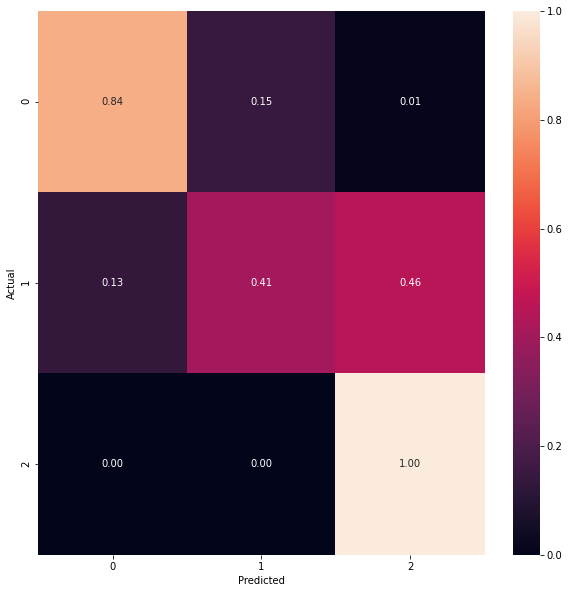

In [ ]:
cm = confusion_matrix(Y_test, best_preds)  
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['0','1','2'], yticklabels=['0','1','2'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

TO TEST:

In [ ]:
test = [-0.920644 ,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357]
test = np.array(test)
test = test.reshape((1,8))
test = pd.DataFrame(test)
test.columns = ['s_2', 's_3', 's_4', 's_7','s_11', 's_12', 's_15', 's_17']
D_dummy_test = xgb.DMatrix(test)
model.predict(D_dummy_test)

array([[9.901980e-01, 9.583864e-03, 2.180981e-04]], dtype=float32)

# **SUPPORT VECTOR MACHINE MODEL**